In [27]:

from keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from keras.models import Model
from keras.layers import Input, Dropout, Dense, Embedding, MultiHeadAttention, LayerNormalization, Layer, Concatenate, add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import load_img
from nltk.translate.bleu_score import corpus_bleu
from wordcloud import WordCloud
import tensorflow as tf
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from glob import glob
from matplotlib import pyplot as plt
from string import punctuation
from tqdm import tqdm

# Introduction
Image captioning is the process of generating text descriptions for images. In this notebook, I develop a model to generate captions for images using transformers.

# Process Captions
To process the captions, I make all of the text lowercase and remove characters that are not letters or whitespace (i.e. numbers, punctuation, other symbols). I also add START and END tokens. I then tokenize the sequences.

In [28]:
df_captions = pd.read_csv('captions.txt')
df_captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [29]:
def remove_punct(str):
    output = ''
    for char in str:
        if char not in punctuation:
            output += char
        else:
            output += ' '
    return output

word_tokenize(remove_punct('light-colored. '))

['light', 'colored']

The text is processed by removing punctuation, non-aphabetic characters and some short words, including articles. Stopword removal harmed model performance substantially. A START and END token are added to the beginning and end of each sequence, so the model can be primed to generate sequences and learn to end them early.

In [30]:
df_captions['caption'] = df_captions['caption'].apply(remove_punct)
df_captions['caption'] = df_captions['caption'].apply(lambda x: 'START ' + ''.join([char for char in x if char.isalpha() or char == ' ']).strip().lower() + ' END')
df_captions['caption'] = df_captions['caption'].apply(lambda x: word_tokenize(x))
df_captions['caption'] = df_captions['caption'].apply(lambda x: [word for word in x if word not in ['a', 'an', 'the'] and len(word) > 1])

df_captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,"[START, child, in, pink, dress, is, climbing, ..."
1,1000268201_693b08cb0e.jpg,"[START, girl, going, into, wooden, building, END]"
2,1000268201_693b08cb0e.jpg,"[START, little, girl, climbing, into, wooden, ..."
3,1000268201_693b08cb0e.jpg,"[START, little, girl, climbing, stairs, to, he..."
4,1000268201_693b08cb0e.jpg,"[START, little, girl, in, pink, dress, going, ..."


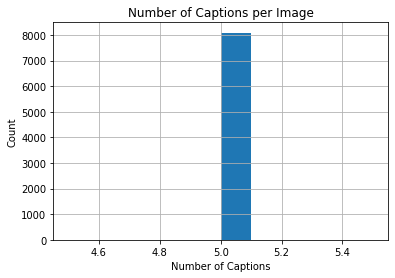

In [31]:
df_captions.groupby('image').count().hist()
plt.title('Number of Captions per Image')
plt.xlabel('Number of Captions')
plt.ylabel('Count')
plt.show()

As shown above, each image has five captions

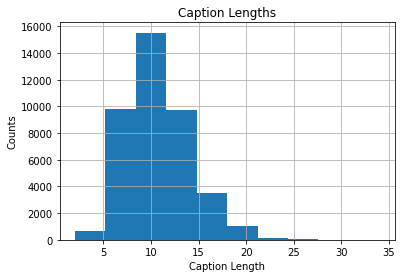

In [32]:
caption_lengths = df_captions['caption'].apply(lambda x: len(x))
caption_lengths.hist()

plt.title('Caption Lengths')
plt.xlabel('Caption Length')
plt.ylabel('Counts')

plt.show()

And we can see here that all of the captions have 35 tokens or less, most less than 15.

# Splitting Data

Next, I separate the image file names into train, validation test sets.

In [33]:

img_ids = df_captions['image'].unique()
train_size = 0.9
val_size = 0.1
test_idx = int(len(img_ids) * train_size)
val_idx = int(test_idx * (1-val_size))
train_ids = img_ids[:val_idx]
val_ids = img_ids[val_idx:test_idx]
test_ids = img_ids[test_idx:]

In [34]:
len(train_ids)

6552

# Vectorizing Captions
The data must be fed into the model as numbers, not text. To do so, mappings are created from tokens to integers. A list of tokens is then "vectorized" as a list of integers. Each integer can further be imagined as shorthand for a vocab_size dimensional one-hot encoded vector, where the integer is the component set to one. This one-hot vector is a ground-truth probability distribution against which predictions will be compared using cross-entropy.

In [35]:
def flatten_corpus(corpus):
    '''
    Takes in a list of lists of tokens and returns a single list of all of the tokens. Effectively the same operation as Numpy's flatten.
    '''
    flat_corpus = []
    for line in corpus:
        flat_corpus.extend(line)
    return flat_corpus

def make_tok2idx(corpus):
    '''
    Take in a list of lists of tokens and returns a dictionary mapping each token to an index
    '''
    flat_corpus = flatten_corpus(corpus)
    unique_toks = list(set(flat_corpus))
    tok2idx = {'PAD':0, 'UNK':1}
    tok_idx = 2
    for tok in unique_toks:
        tok2idx[tok] = tok_idx
        tok_idx += 1
    return tok2idx

df_train = df_captions.loc[df_captions['image'].isin(train_ids), 'caption']
tok2idx = make_tok2idx(df_train)
idx2tok = dict((value, key) for key, value in tok2idx.items())    

In [36]:
def vectorize_seq(sequence):
    '''
    Takes in a list of tokens and returns a list of indices.
    '''
    vector = []
    for tok in sequence:
        next_idx = tok2idx.get(tok)
        if next_idx is not None:
            vector.append(next_idx)
        else:
            vector.append(tok2idx['UNK'])
    return vector

def get_max_len(sequences):
    '''
    Takes in a list of lists of tokens and returns the length of the longest sequence.
    '''
    sequences = [vectorize_seq(seq) for seq in sequences]
    max_len = np.max([len(vector) for vector in sequences])
    return max_len

max_len = get_max_len(df_train)

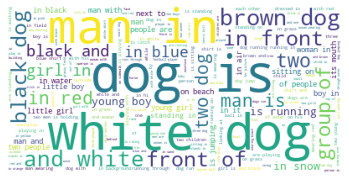

In [37]:
wc = WordCloud(repeat=False, background_color='white', stopwords=['START', 'END'])
wc.generate(' '.join(flatten_corpus(df_train)))

plt.axis('off')
plt.imshow(wc)
plt.show()

# Image Feature Extraction
To extract features from images, I use a ResNet50V2 model with ImageNet weights. Note the final layer is an average pooling layer. This leads to marginally better performance than max_pooling. Intuitively, average pooling encodes more information about the space being pooled, since it averages pooled values rather than discarding all but the largest.

In [38]:
target_size = (224, 224) # original resnet size

resnet = ResNet50V2(include_top=False, input_shape=target_size + (3,), pooling='avg')
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

To save on memory, I will not load the images now. Rather, I will write a generator that will load samples as the models train.

# Model Training Input Processing
The text inputs and targets are processed like sequence to sequence inputs and outputs, i.e. the output is the input shifted by one.

The model is trained from a generator due to memory constraints.

In [39]:
def load_img_descriptions(img_ids, max_len=max_len):
    '''
    Processes the caption for an image ID. Returns the inputs and targets for the ID.
    '''
    descriptions = df_captions.loc[df_captions['image'].isin(img_ids)]['caption'].values
    descriptions = [vectorize_seq(description) for description in descriptions]
    inputs = np.zeros((len(descriptions), max_len))
    targets = np.zeros((len(descriptions), max_len))
    
    for i, description in enumerate(descriptions):
        for j, tok in enumerate(description):
            inputs[i][j] = tok
            if j > 0: # targets = inputs shifted by 1
                targets[i][j-1] = tok
    return inputs, targets

In [40]:
def data_gen(generator_ids, img_dir, batch_size):
    '''
    Yields a batch of data: text inputs, text targets, and image features.
    '''
    while True:
        num_samples = len(generator_ids)
        start_idx = 0
        num_caption_per_img = 5
        for i in range(0, num_samples, batch_size):
            
            # Get a batch of ids
            end_idx = start_idx + batch_size
            if end_idx >= num_samples:
                batch = generator_ids[start_idx:]
            else:
                batch = generator_ids[start_idx:end_idx]
            start_idx += batch_size
            
            # Load images
            img_locs = [img_dir+'/'+id for id in batch]
            images = np.asarray([np.asarray(load_img(img_loc, target_size=target_size)) for img_loc in img_locs])
            images = np.asarray([preprocess_input(img) for img in images])
            img_features = resnet.predict(images, verbose=0)
            img_features = tf.concat([tf.repeat(tf.expand_dims(feats, axis=0), num_caption_per_img, axis=0) for feats in img_features], axis=0)
            
            # Get text sequences
            text_inputs, text_targets = load_img_descriptions(batch)
            

            yield (text_inputs, img_features), text_targets

# Positional Embeddings and Transformer Decoder
This section contains layers needed for the transformer and a layer to combine text and image features. The first is a positional embedding feature. Transformers have many benefits over RNNs, but they do not by themselves encode position. The positional embedding here is simple. The model learns embeddings both encode positional information and semantic information. The positional embeddings are an element-wise sum of those weights.

The transformer is the transformer decoder from [Attention is All You Need](https://arxiv.org/abs/1706.03762). While it does not affect the architecture of the transformer decoder, it should be noted that in the paper the transformer was used for machine translation in a sequence to sequence architecture, thus the decoder performed self-attention and attention between source and target language sequences. Here, the decoder only performs self-attention.

Finally, there is a custom addition layer.  Here, the image features are (batch_size, 2048), but transformer outputs are (batch_size, max_len, embed_dim). I project the image layers down to embed_dim with a dense layer, then pass those projections to the custom addition layer. This addition layer repeats the image feature projections and reshapes them to (batch_size, max_len, embed_dim), i.e. each batch has max_len image feature projections. The image features and transformer outputs can then be added together.

This custom addittion layer is simply an extrapolation from the process in [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137). In [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137), addition is described as the best way to combine image and text features. However in that paper, they use an RNN where I use the transformer decoder (in addition to performing a slightly diifferent training task, discussed below). Thus in that application addition is trivial - the image features are of some fixed size, say (1, feature_size), so if the RNN's hidden vectors are made to be the same size, the final RNN hidden statee can be added to the image features.

In [41]:
class PositionalEmbedding(Layer):
    def __init__(self, seq_len, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.tok_embedding = Embedding(vocab_size, embed_dim)
        self.pos_embedding = Embedding(seq_len, embed_dim)
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        
    def call(self, x):
        tok_embeds = self.tok_embedding(x)
        
        positions = tf.range(0, tf.shape(x)[-1])
        pos_embeds = self.pos_embedding(positions)
        return tf.add(pos_embeds, tok_embeds)
    
    def compute_mask(self, inputs, mask=None):
        mask = tf.math.not_equal(inputs, 0)
        return mask
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'seq_len': self.seq_len,
                'vocab_size': self.vocab_size,
                'embed_dim': self.embed_dim
            }
        )
        return config

In [42]:
class TransformerDecoder(Layer):
    def __init__(self, num_heads, embed_dim, dense_units, dropout=0.0, **kwargs):
        '''
        Transformer decoder using Vaswani attention.
        Parameters: num_heads, number of heads for multi-head attention
                    embed_dim, embedding dimension of input sequences
                    dense_units, number of units in non-linear dense layer
        '''
        super().__init__(**kwargs)
        self.self_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)
        self.dense = Dense(dense_units, activation='relu')
        self.linear = Dense(embed_dim)
        self.self_attention_layernorm = LayerNormalization()
        self.attention_layernorm = LayerNormalization()
        self.dense_layernorm = LayerNormalization()
        self.num_heads = num_heads
        self.key_dim = embed_dim 
        self.dense_units = dense_units
        self.supports_masking = True
        self.dropout_rate = dropout
        
    def call(self, query, values, mask=None, track_weights=False):
        '''
        Forward pass for transformer decoder using Vaswani attention
        '''
        # Make causal masks
        causal_mask = self.make_causal_mask(query)
        
        # Make padding mask
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            padding_mask = tf.minimum(padding_mask, causal_mask) # Masks both "future" targets the model shouldn't see and padding tokens
        
        # Self-attention
        self_attention_output = self.self_attention(query, query, attention_mask=causal_mask)
        normed_self_attention_output = self.self_attention_layernorm(values + self_attention_output)
        
        # Attention over encoder inputs
        attention_output = self.attention(normed_self_attention_output, values, attention_mask=padding_mask)
        normed_attention_outputs = self.attention_layernorm(attention_output + normed_self_attention_output)
        
        # Projections wiith dense layers
        x = self.dense(normed_attention_outputs)
        x = self.linear(x)
        decoder_outputs = self.dense_layernorm(x + normed_attention_outputs)
        
        return decoder_outputs
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'num_heads': self.num_heads,
                'key_dem': self.key_dim,
                'dense_units': self.dense_units,
                'dropout_rate': self.dropout_rate
            }
        )
        return config
        
    def make_causal_mask(self, inputs): 
        '''
        Makes a mask to prevent attention layers from seeing future characters during training
        '''
        inputs_shape = tf.shape(inputs) 
        batch_size, seq_len = inputs_shape[0], inputs_shape[1]
        a = tf.range(seq_len)[:, tf.newaxis]
        b = tf.range(seq_len)

        causal_mask = tf.cast(a >= b, 'int32') # creates a (seq_len, seq_len) LT matrix with ones on and below diag

        # Stack batch_size causal masks on top of each other
        causal_mask = tf.reshape(causal_mask, (1, seq_len, seq_len))
        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1,1], dtype='int32')], axis=0)
        causal_mask = tf.tile(causal_mask, mult)
        return causal_mask

In [43]:
class AddImageToText(Layer):
    '''
    Adds the feature from an image to the output of a transformer called on a text sequence. The transformer returns (batch_size, seq_len, embed_dim) while the image features are only (batch_size, embed_dim), so the image 
    features are repeated seq_len times for each sample in the batch
    '''
    def __init__(self, seq_len, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.supports_masking = True
        
    def call(self, img, text_sequence):
        img = tf.repeat(img, self.seq_len, axis=0)
        img = tf.reshape(img, shape=(-1, self.seq_len, self.embed_dim))
        sum = tf.add(img, text_sequence)
        return sum
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'embed_dim': self.embed_dim,
                'seq_len': self.seq_len
            }
        )
        return config

# Build Model
The model architecture is very similar to an encoder-decoder architecture, but with separate "encoders" for text and image data. The encoder for the image data is just the pretrained resnet model - this is called in the data generator. The encoder for the text data is a transformer. Since transformers have no concept of sequence order, positional embeddings are used. The encoded data is combined and fed into the decoder, which is a simple classification model. The outputs are sequences of distributions calculated using a softmax function. In this sense, the model is roughly a sequence to sequence model.

This model is similar to the injection model described in the paper [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137) with two notable exceptions. First, the paper uses an RNN as the text encoder, while I use a transformer. Second, my model is trained an a pseudo-sequence-to-sequence fashion in the sense that inputs are a sequence and outputs are the sequence shifted by one. This is a more natural use of a transformer than the training method described in the paper, in my opinion.

In [47]:
num_heads = 4
transformer_dense_units = 2048
transformer_dropout_rate = 0.0
dropout_rate = 0.5
embed_dim = 256
vocab_size = len(tok2idx)

In [48]:

# Text encoder
text_inputs = Input(shape=(None,), name='text_inputs')
text_inputs = Dropout(dropout_rate)(text_inputs)

text_embedding_layer = PositionalEmbedding(seq_len=max_len, vocab_size=vocab_size, embed_dim=embed_dim, name='text_embeds')
text_embeds = text_embedding_layer(text_inputs)

text_embeds = Dropout(dropout_rate)(text_embeds)

text_transformer = TransformerDecoder(num_heads=num_heads, embed_dim=embed_dim, dense_units=transformer_dense_units, dropout=transformer_dropout_rate)
text_encoded = text_transformer(text_embeds, text_embeds)


# Image_encoder
image_inputs = Input(shape=(2048,), name='image_inputs')
image_inputs = Dropout(dropout_rate)(image_inputs)
image_encoded = Dense(embed_dim, activation='relu')(image_inputs)

# Combine encoded data
encoded = AddImageToText(seq_len=max_len, embed_dim=embed_dim)(image_encoded, text_encoded)

# "Decoder"
x = Dropout(dropout_rate)(encoded)
x = Dense(2048, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(vocab_size, activation='softmax')(x)

model = Model([text_inputs, image_inputs], outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 text_embeds (PositionalEmbeddi  (None, None, 256)   1991168     ['input_7[0][0]']                
 ng)                                                                                              
                                                                                                  
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_11 (Dropout)           (None, None, 256)    0           ['text_embeds[1][0]']      

In [49]:
batch_size = 6 # This corresponds to 30 sets of inputs a batch       
train_gen = data_gen(train_ids, 'images', batch_size=batch_size)
val_gen = data_gen(val_ids, 'images', batch_size=batch_size)

lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, min_delta=0.01, patience=5, min_lr=1e-6)
es = EarlyStopping(monitor='val_loss', verbose=1, min_delta=0.01, patience=10, restore_best_weights=True)


model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy')
history = model.fit(train_gen, 
          steps_per_epoch=len(train_ids)//batch_size, 
          validation_data=val_gen, 
          validation_steps=(len(val_ids))//batch_size, 
          epochs=200, 
          callbacks=[lr, es])

Epoch 1/200
1092/1092 [==============================] - 91s 82ms/step - loss: 1.2154 - val_loss: 1.0907 - lr: 0.0010
Epoch 2/200
1092/1092 [==============================] - 89s 82ms/step - loss: 0.9374 - val_loss: 1.0832 - lr: 0.0010
Epoch 3/200
1092/1092 [==============================] - 89s 82ms/step - loss: 0.7984 - val_loss: 1.1534 - lr: 0.0010
Epoch 4/200
1045/1092 [===========================>..] - ETA: 3s - loss: 0.6921

KeyboardInterrupt: 

# Inference
Inference is similar to a sequence to sequence model. First the "START" token is fed into the model along with an image. The next token is selected using the argmax of the final model output. The next token is added to the input sequence, which is then fed into the model. This process repeats until either the model predicts an END token or it produces a sentence of some maximum length.

In [ ]:
def vec_to_tok(vector):
    return [idx2tok[tok] for tok in vector]

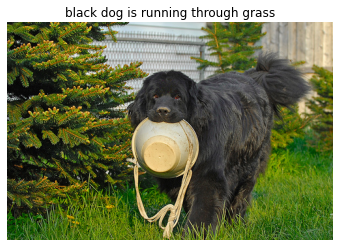

GROUND TRUTH LABELS
black dog carries bucket in its mouth
black dog carrying hanging flower pot
dog next to pine tree biting on bucket
furry black dog in backyard carrying basket in its mouth
furry dog is walking by green trees while carrying something in its mouth


In [ ]:
def get_caption(img_path):
    caption_string = 'START'
    image = np.asarray(load_img(img_path, target_size=target_size))
    image = np.expand_dims(preprocess_input(image), 0)
    image_features = resnet(image)
    for i in range(max_len):
        caption_idxs = vectorize_seq(caption_string.split(' '))
        vectorized_sentence = np.zeros((1, max_len))
        for i, idx in enumerate(caption_idxs):
            vectorized_sentence[0][i] = idx
        
        # Get next token index
        prediction = model([vectorized_sentence, image_features])
        next_tok_idx = np.argmax(prediction[0, i, :])
        
        # Update string
        next_tok = idx2tok[next_tok_idx]
        caption_string += ' ' + next_tok
        
        # Break if END predicted
        if next_tok == 'END':
            break
        
    if caption_string.endswith('END'):
        return ' '.join(caption_string.split(' ')[1:-1])
    else:
        return ' '.join(caption_string.split(' ')[1:])
    

def plot_img(img_loc, caption=None):
    img = load_img(img_loc)
    plt.axis('off')
    plt.title(caption)
    plt.imshow(img)
    plt.show()

idx = 300
img_id = test_ids[idx]
img_dir = 'images'
img_loc = img_dir + '/' + img_id
pred_caption = get_caption(img_loc)

plot_img(img_loc, pred_caption)
print('GROUND TRUTH LABELS')
true_captions = [' '.join(caption_list[1:-1]) for caption_list in  df_captions[df_captions['image'] == test_ids[idx]]['caption'].values]
for caption in true_captions:
    print(caption)


# Model Evaluation
The model is evaluated using BLEU score. BLEU-N score quantifies the degree of overlap between N-grams in a hypothesis captions and a corresponding set of reference sequences.

In [ ]:
pred_caption_dict = {}
for id in tqdm(test_ids):
    img_loc = 'images/'+id
    pred_caption_dict[id] = get_caption(img_loc)

100%|██████████| 810/810 [02:20<00:00,  5.77it/s]


In [ ]:
references = []
hypotheses = []
for id in test_ids:
    true_captions = [caption_list for caption_list in  df_captions[df_captions['image'] == id]['caption'].values]
    references.append(true_captions)
    hypotheses.append(word_tokenize(pred_caption_dict[id]))

In [ ]:
bleu_1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, hypotheses, weights=(1/3, 1/3, 1/3, 0))
bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

print(f'BLEU-1: {bleu_1}')
print(f'BLEU-2: {bleu_2}')
print(f'BLEU-3: {bleu_3}')
print(f'BLEU-4: {bleu_4}')

BLEU-1: 0.34838874113886525
BLEU-2: 0.20245581721900902
BLEU-3: 0.11770450836248893
BLEU-4: 0.0675385770761592


# Conclusion
This model is outperformed by the RNN model. The transformer architecture encodes fewer assumptions about the structure of the data, in addition to having much more parameters, than an RNN model. I suspect this makes the model more difficult to train. Additionally, recall from above that the captions are short. One problem with RNNs is that they compute a hidden vector meant to capture a sequence sequentially. For long sequences, the RNN may not "remember" information from early in the sequence. Transformers, specifically attention, remedy this problem, but that benefit will be less pronounced for short sequences.